In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/samokhinv/control-variates.git

fatal: destination path 'control-variates' already exists and is not an empty directory.


In [ ]:
import sys
#sys.path.append('..')
sys.path.append('control-variates')
from control_variates.uncertainty_quantification import ClassificationUncertaintyMCMC
import dill as pickle
from mnist_utils import load_mnist_dataset
from control_variates.model import LogRegression
from control_variates.cv import PsyLinear, SteinCV, PsyConstVector
from control_variates.cv_utils import state_dict_to_vec, compute_naive_variance, compute_ll_div
from control_variates.model import get_binary_prediction
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
with open('drive/My Drive/saved_samples/mnist_weights/sgld_samples.pkl', 'rb') as fp:
    samples = pickle.load(fp)
# with open('../../saved_samples/mnist_weights/30_samples_seed-1.pkl', 'rb') as fp:
#     samples = pickle.load(fp)

In [ ]:
with open('drive/My Drive/saved_samples/mnist_weights/sgld_linear_cv_reg.pkl', 'rb') as fp:
    psy_weights = pickle.load(fp)
# with open('../../data/psy_weights.pckl', 'rb') as fp:
#     psy_weights = pickle.load(fp)

In [ ]:
samples = samples[:len(psy_weights)]
#samples = [(x[0][::5], x[1]) for x in samples] 

In [ ]:
print(len(samples[0][0]))

200


In [ ]:

train_dl, valid_dl = load_mnist_dataset('drive/My Drive/data/mnist/', 20000, [3, 5])

In [ ]:
x_new, y_new = next(iter(valid_dl))
train_x, train_y = next(iter(train_dl))

In [ ]:
N_train = len(train_dl.dataset)

In [ ]:
trajectories = [[LogRegression(784)
                 for j in range(len(samples[i][0]))]
                for i in range(len(samples))]

for i in range(len(samples)):
    for j in range(len(samples[i][0])):
        trajectories[i][j].load_state_dict(samples[i][0][j])

priors = [samples[i][1] for i in range(len(samples))]

ll_divs = [compute_ll_div(ms, train_x, train_y, N_train, priors=ps) for ms, ps in zip(trajectories, priors)]

In [ ]:
# import random
# random.seed(42)

# traj, prior = samples[0]
# new_samples = []
# for _ in range(10):
#     new_samples.append((random.sample(traj, 15), prior))


# trajectories = [[LogRegression(784)
#                  for j in range(len(new_samples[i][0]))]
#                 for i in range(len(new_samples))]

# for i in range(len(new_samples)):
#     for j in range(len(new_samples[i][0])):
#         trajectories[i][j].load_state_dict(new_samples[i][0][j])

# priors = [new_samples[i][1] for i in range(len(new_samples))]

In [ ]:
# psy_models2 = [PsyLinear(1570) for _ in range(len(psy_weights2))]
# for i in range(len(psy_weights)):
#     psy_models2[i].load_state_dict(psy_weights2[i])

psy_models = [PsyLinear(1570) for _ in range(len(psy_weights))]
for i in range(len(psy_weights)):
    psy_models[i].load_state_dict(psy_weights[i])

# psy_models = [PsyConstVector(1570) for _ in range(len(psy_weights))]
# for i in range(len(psy_weights)):
#     psy_models[i].load_state_dict(psy_weights[i])

In [ ]:
ncv_s = [SteinCV(psy_model, train_x, train_y, prior, len(train_dl.dataset), ll_div=ll_div) \
         for psy_model, prior, ll_div in zip(psy_models, priors, ll_divs)]

In [ ]:
psy_weights[0]

OrderedDict([('layer.weight',
              tensor([[-7.0730e-05,  6.1482e-06, -1.4517e-06,  ..., -6.6033e-06,
                       -2.6463e-06,  2.6047e-05]])),
             ('layer.bias', tensor([4.0239e-07]))])

In [ ]:
# from torch.nn import functional as F

# x = x_new[y_new == 1.0][[43]]
# predictions = [F.softmax(model(x), -1) for model in trajectories[0]]

In [ ]:
x = x_new[y_new == 1.0][[43]]

In [ ]:
ncv_s[0](trajectories[0], x, ll_div=ll_divs[0]).mean()
#uq.get_cv_values(x.unsqueeze(0)).mean()

tensor(0.0002, grad_fn=<MeanBackward0>)

6


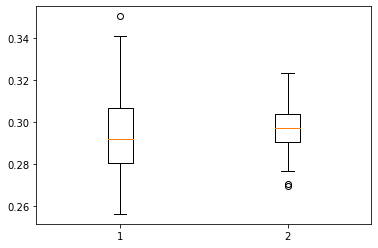

In [ ]:
import random

idx = random.randint(0, len(trajectories))
print(idx)
models = trajectories[idx]
ncv = ncv_s[idx]
uq = ClassificationUncertaintyMCMC(models, ncv)
        #print(uq.estimate_emperical_mean(x.unsqueeze(0), use_cv=True))
        #print(uq.estimate_emperical_mean(x.unsqueeze(0), use_cv=False))
predictions_no_cv = uq.get_predictions(x.unsqueeze(0))#.detach().numpy()
predictions_cv = predictions_no_cv - uq.get_cv_values(x.unsqueeze(0))#.tolist()
fig7, ax7 = plt.subplots()
#ax7.boxplot(predictions)
ax7.boxplot([predictions_no_cv[:, 0].tolist(), predictions_cv[:, 0].tolist()])
#ax7.boxplot([v, v2])

plt.savefig('cv.png')
plt.show()

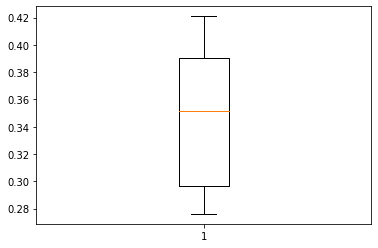

In [ ]:
x = x_new[y_new == 1.0][[43]]

l = [get_binary_prediction(models, x, [0,1]).mean().item() for models in trajectories]

plt.boxplot(l)
plt.show()

10it [00:05,  1.85it/s]


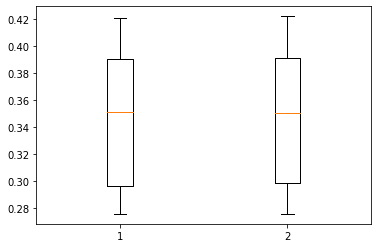

In [ ]:
 for x in x_new[y_new == 1.0][[43]]:
    predictions_cv, v = [], []
    predictions_no_cv, v2 = [], []
    for models, ncv in tqdm(zip(trajectories, ncv_s)):
        uq = ClassificationUncertaintyMCMC(models, ncv)

        predictions_cv.append(uq.estimate_emperical_mean(x.unsqueeze(0), use_cv=True).mean().item())
        v.append(uq.estimate_emperical_variance(x.unsqueeze(0), use_cv=True).mean().item())
        predictions_no_cv.append(uq.estimate_emperical_mean(x.unsqueeze(0), use_cv=False).mean().item())
        v2.append(uq.estimate_emperical_variance(x.unsqueeze(0), use_cv=False).mean().item())
    fig7, ax7 = plt.subplots()
    #ax7.boxplot(predictions)
    ax7.boxplot([predictions_no_cv, predictions_cv])
    #ax7.boxplot([v, v2])
    plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline
# fig7, ax7 = plt.subplots()
# #ax7.boxplot(predictions)
# ax7.boxplot([predictions, predictions2])

In [ ]:
uq.estimate_emperical_mean(x.unsqueeze(0), use_cv=False)

tensor([0.3743], grad_fn=<MeanBackward1>)

In [ ]:
uq.estimate_emperical_mean(x.unsqueeze(0), use_cv=True)

In [ ]:
x.unsqueeze(0).shape

In [ ]:
uq.estimate_emperical_variance(x.unsqueeze(0), use_cv=False)

In [ ]:
models

[LogRegression(
   (linear): Linear(in_features=784, out_features=2, bias=True)
 ), LogRegression(
   (linear): Linear(in_features=784, out_features=2, bias=True)
 ), LogRegression(
   (linear): Linear(in_features=784, out_features=2, bias=True)
 ), LogRegression(
   (linear): Linear(in_features=784, out_features=2, bias=True)
 ), LogRegression(
   (linear): Linear(in_features=784, out_features=2, bias=True)
 ), LogRegression(
   (linear): Linear(in_features=784, out_features=2, bias=True)
 ), LogRegression(
   (linear): Linear(in_features=784, out_features=2, bias=True)
 ), LogRegression(
   (linear): Linear(in_features=784, out_features=2, bias=True)
 ), LogRegression(
   (linear): Linear(in_features=784, out_features=2, bias=True)
 ), LogRegression(
   (linear): Linear(in_features=784, out_features=2, bias=True)
 ), LogRegression(
   (linear): Linear(in_features=784, out_features=2, bias=True)
 ), LogRegression(
   (linear): Linear(in_features=784, out_features=2, bias=True)
 ), Log